In [1]:
import nltk
import unicodedata
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from matplotlib import RcParams
from nltk.corpus import stopwords
from statsmodels.distributions.empirical_distribution import ECDF
import os
nltk.download('stopwords')

In [2]:
stop = stopwords.words('spanish')

In [4]:
lista = ["id_trn_ach","id_cliente","fecha","hora","valor_trx","ref1","ref2","ref3","sector","subsector","descripcion","11","12","13"]
datos = pd.read_csv('dt_trxpse_personas_2016_2018_muestra_adjt.csv', sep=',', names=lista, header= None, parse_dates=[['fecha', 'hora']])
datos.head()

C:\Users\stiven.lopez\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,fecha_hora,id_trn_ach,id_cliente,valor_trx,ref1,ref2,ref3,sector,subsector,descripcion,11,12,13
0,20161207 113451,230435642,3,2122392.51,CC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,20161016 3424,222356110,10,148438.37,Referencia: Contrato: Valor:,CC,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20180120 195042,309137749,10,94025.19,CC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,20180326 192146,324614737,10,94430.07,CC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,20170106 201317,235344690,18,670645.57,MEDICINA PREPAGADA COLSANITAS,CE,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
datos = datos.drop(datos.columns[[5, 6, 10, 11, 12]], axis=1)
datos.head()

,fecha_hora,id_trn_ach,id_cliente,valor_trx,ref1,sector,subsector,descripcion
0,20161207 113451,230435642,3,2122392.51,CC,NaN,NaN,NaN
1,20161016 3424,222356110,10,148438.37,Referencia: Contrato: Valor:,NaN,NaN,NaN
2,20180120 195042,309137749,10,94025.19,CC,NaN,NaN,NaN
3,20180326 192146,324614737,10,94430.07,CC,NaN,NaN,NaN
4,20170106 201317,235344690,18,670645.57,MEDICINA PREPAGADA COLSANITAS,NaN,NaN,NaN


## Transformación de datos

In [6]:
datos = datos[datos['valor_trx'] < 50000000]

In [7]:
datos['ref1'] = datos['ref1'].astype('str')
datos['descripcion'] = datos['descripcion'].astype('str')

In [8]:
datos['ref1'] = datos['ref1'].str.replace('+',' ').str.replace('_',' ')
datos['descripcion'] = datos['descripcion'].str.replace('+',' ').str.replace('_',' ')

In [9]:
def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    only_ascii = nfkd_form.encode('ASCII', 'ignore')
    return only_ascii.decode('utf-8')

datos['ref1'] = datos['ref1'].apply(remove_accents)
datos['descripcion'] = datos['descripcion'].apply(remove_accents)

In [10]:
datos['ref1'] =  datos['ref1'].str.replace(r"[^a-zA-Z0-9 ]+", "").str.strip()
datos['descripcion'] =  datos['descripcion'].str.replace(r"[^a-zA-Z0-9 ]+", "").str.strip()

In [11]:
datos['ref1'] = datos['ref1'].str.lower()

datos['sector'] = datos['sector'].str.lower()
datos['subsector'] = datos['subsector'].str.lower()
datos['descripcion'] = datos['descripcion'].str.lower()

In [12]:
datos['ref1'] = datos['ref1'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
datos['descripcion'] = datos['descripcion'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

In [13]:
datos.head(10)

,fecha_hora,id_trn_ach,id_cliente,valor_trx,ref1,sector,subsector,descripcion
0,20161207 113451,230435642,3,2122392.51,cc,NaN,NaN,nan
1,20161016 3424,222356110,10,148438.37,referencia contrato valor,NaN,NaN,nan
2,20180120 195042,309137749,10,94025.19,cc,NaN,NaN,nan
3,20180326 192146,324614737,10,94430.07,cc,NaN,NaN,nan
4,20170106 201317,235344690,18,670645.57,medicina prepagada colsanitas,NaN,NaN,nan
5,20180307 143513,320049316,18,706933.70,recaudo colsanitas,NaN,NaN,nan
6,20161207 155840,230519178,19,306773.79,cc,NaN,NaN,nan
7,20170210 142809,241307506,19,701067.98,pago planilla cesantias,servicios financieros,otros servicios financieros,actividades auxiliares actividades servicios f...
8,20180220 153148,316193109,24,767571.01,cc,NaN,NaN,nan
9,20170914 70026,282076350,26,100277.45,pago factura conjunto residencial pietra santa ph,NaN,NaN,nan


In [14]:
#iqr = datos["valor_trx"].quantile(0.75)-datos["valor_trx"].quantile(0.25)

In [18]:
#r_2 = datos['valor_trx'].mean() + 2*iqr
#r_3 = datos['valor_trx'].mean() + 3*iqr
#d_2 = datos['valor_trx'].mean() + 2*datos['valor_trx'].std()
d_3 = datos['valor_trx'].mean() + 3*datos['valor_trx'].std()
#q = datos["valor_trx"].quantile(0.75) + 1.5*iqr

In [19]:
#print(r_2, r_3, d_2, d_3, q)

In [20]:
#df = datos[(datos['valor_trx'] > 1600) & (datos['valor_trx'] < r_2)]
#df1 = datos[(datos['valor_trx'] > 1600) & (datos['valor_trx'] < r_3)]
#df2 = datos[(datos['valor_trx'] > 1600) & (datos['valor_trx'] < d_2)]
datos = datos[(datos['valor_trx'] > 1600) & (datos['valor_trx'] < d_3)]
#df4 = datos[(datos['valor_trx'] > 1600) & (datos['valor_trx'] < q)]

In [21]:
#print(datos.shape)
#print(df.shape[0]/datos.shape[0])
#print(df1.shape[0]/datos.shape[0])
#print(df2.shape[0]/datos.shape[0])
#print(df3.shape[0]/datos.shape[0])
#print(df4.shape[0]/datos.shape[0])

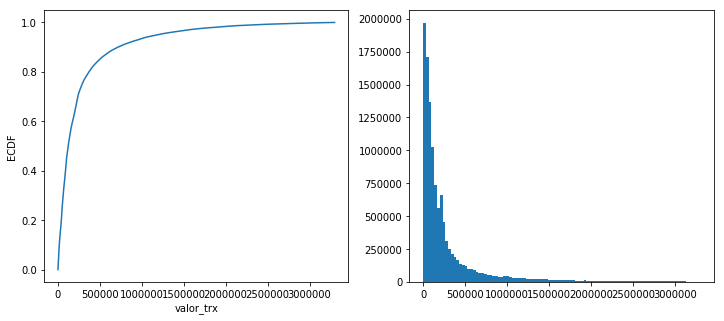

In [22]:
plt.figure(figsize = (12, 5)) 
# ECDF
plt.subplot(121)
cdf = ECDF(datos['valor_trx'])
plt.plot(cdf.x, cdf.y, label = "statmodels");
plt.xlabel('valor_trx'); plt.ylabel('ECDF');

# overall distribution
plt.subplot(122)
plt.hist(datos['valor_trx'].dropna(), bins=100);

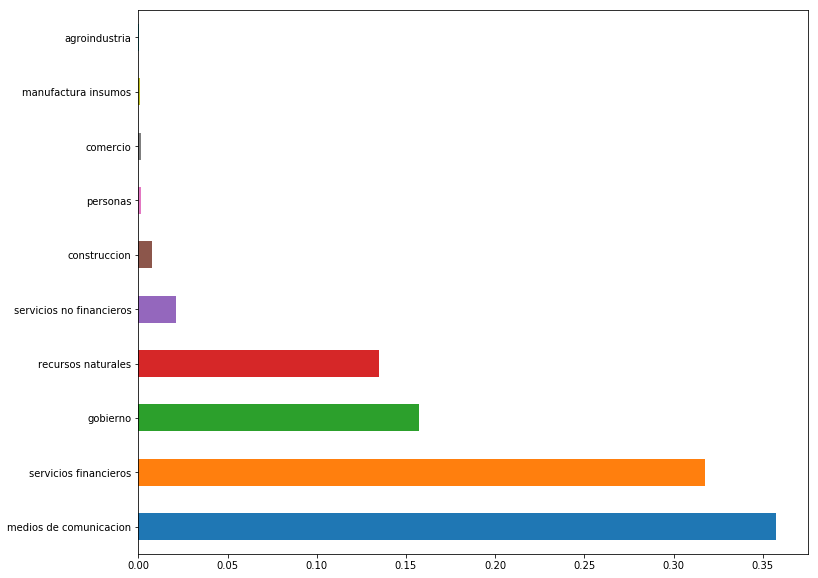

In [23]:
plt.figure(figsize=(12,10))
datos.sector.value_counts(True).plot.barh()

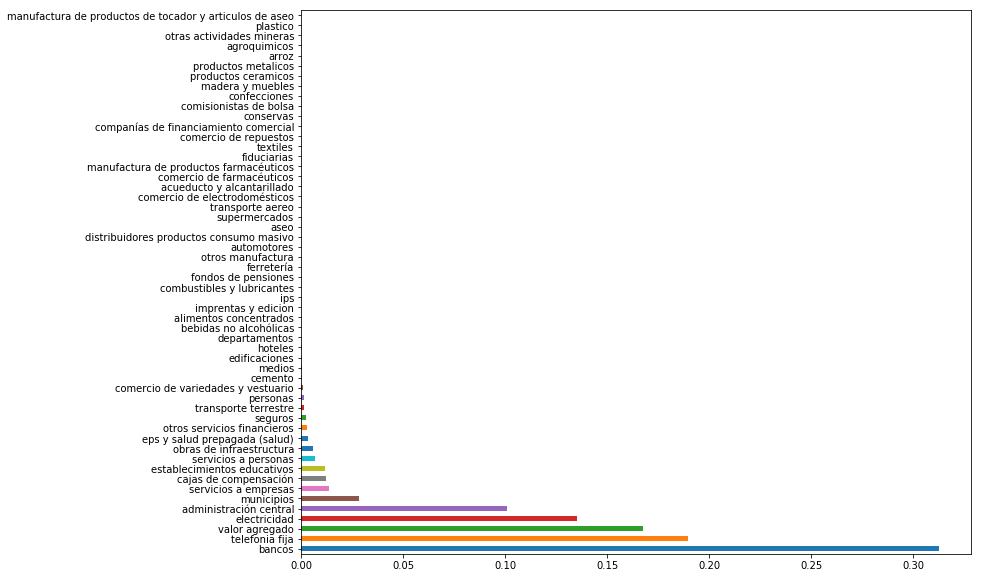

In [24]:
plt.figure(figsize=(12,10))
datos.subsector.value_counts(True).plot.barh()

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

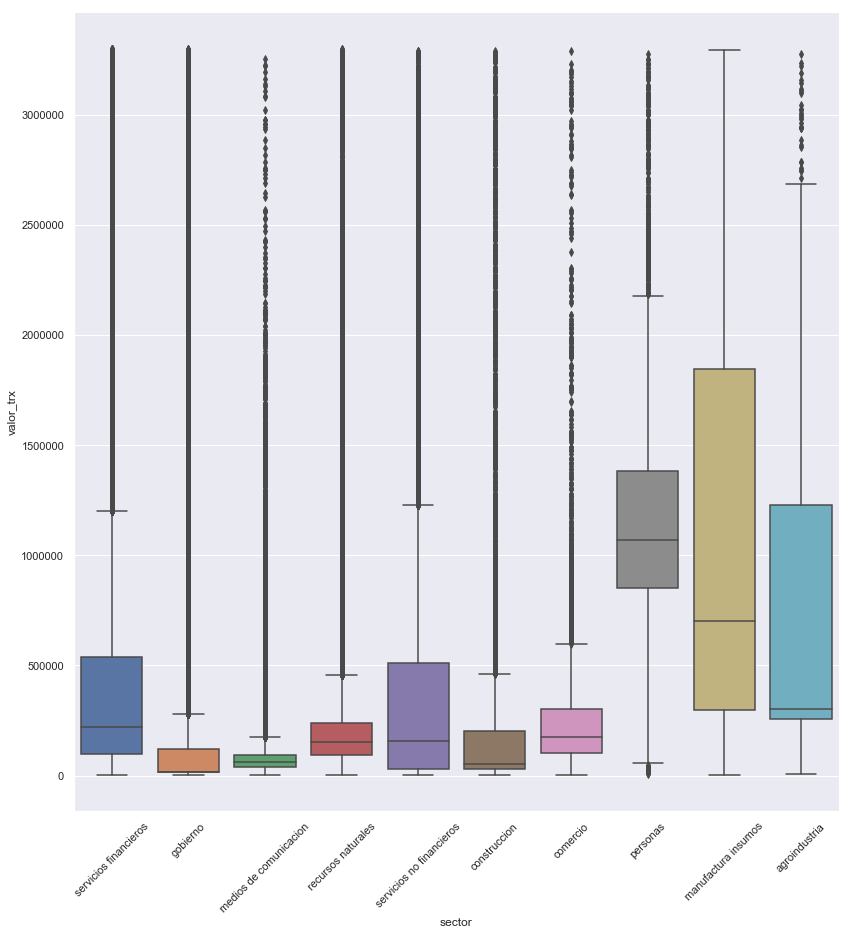

In [25]:
sns.set()
sns.catplot(x="sector", y="valor_trx", kind="box", data=datos, height=12)
plt.xticks(rotation=45)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53]), <a list of 54 Text xticklabel objects>)

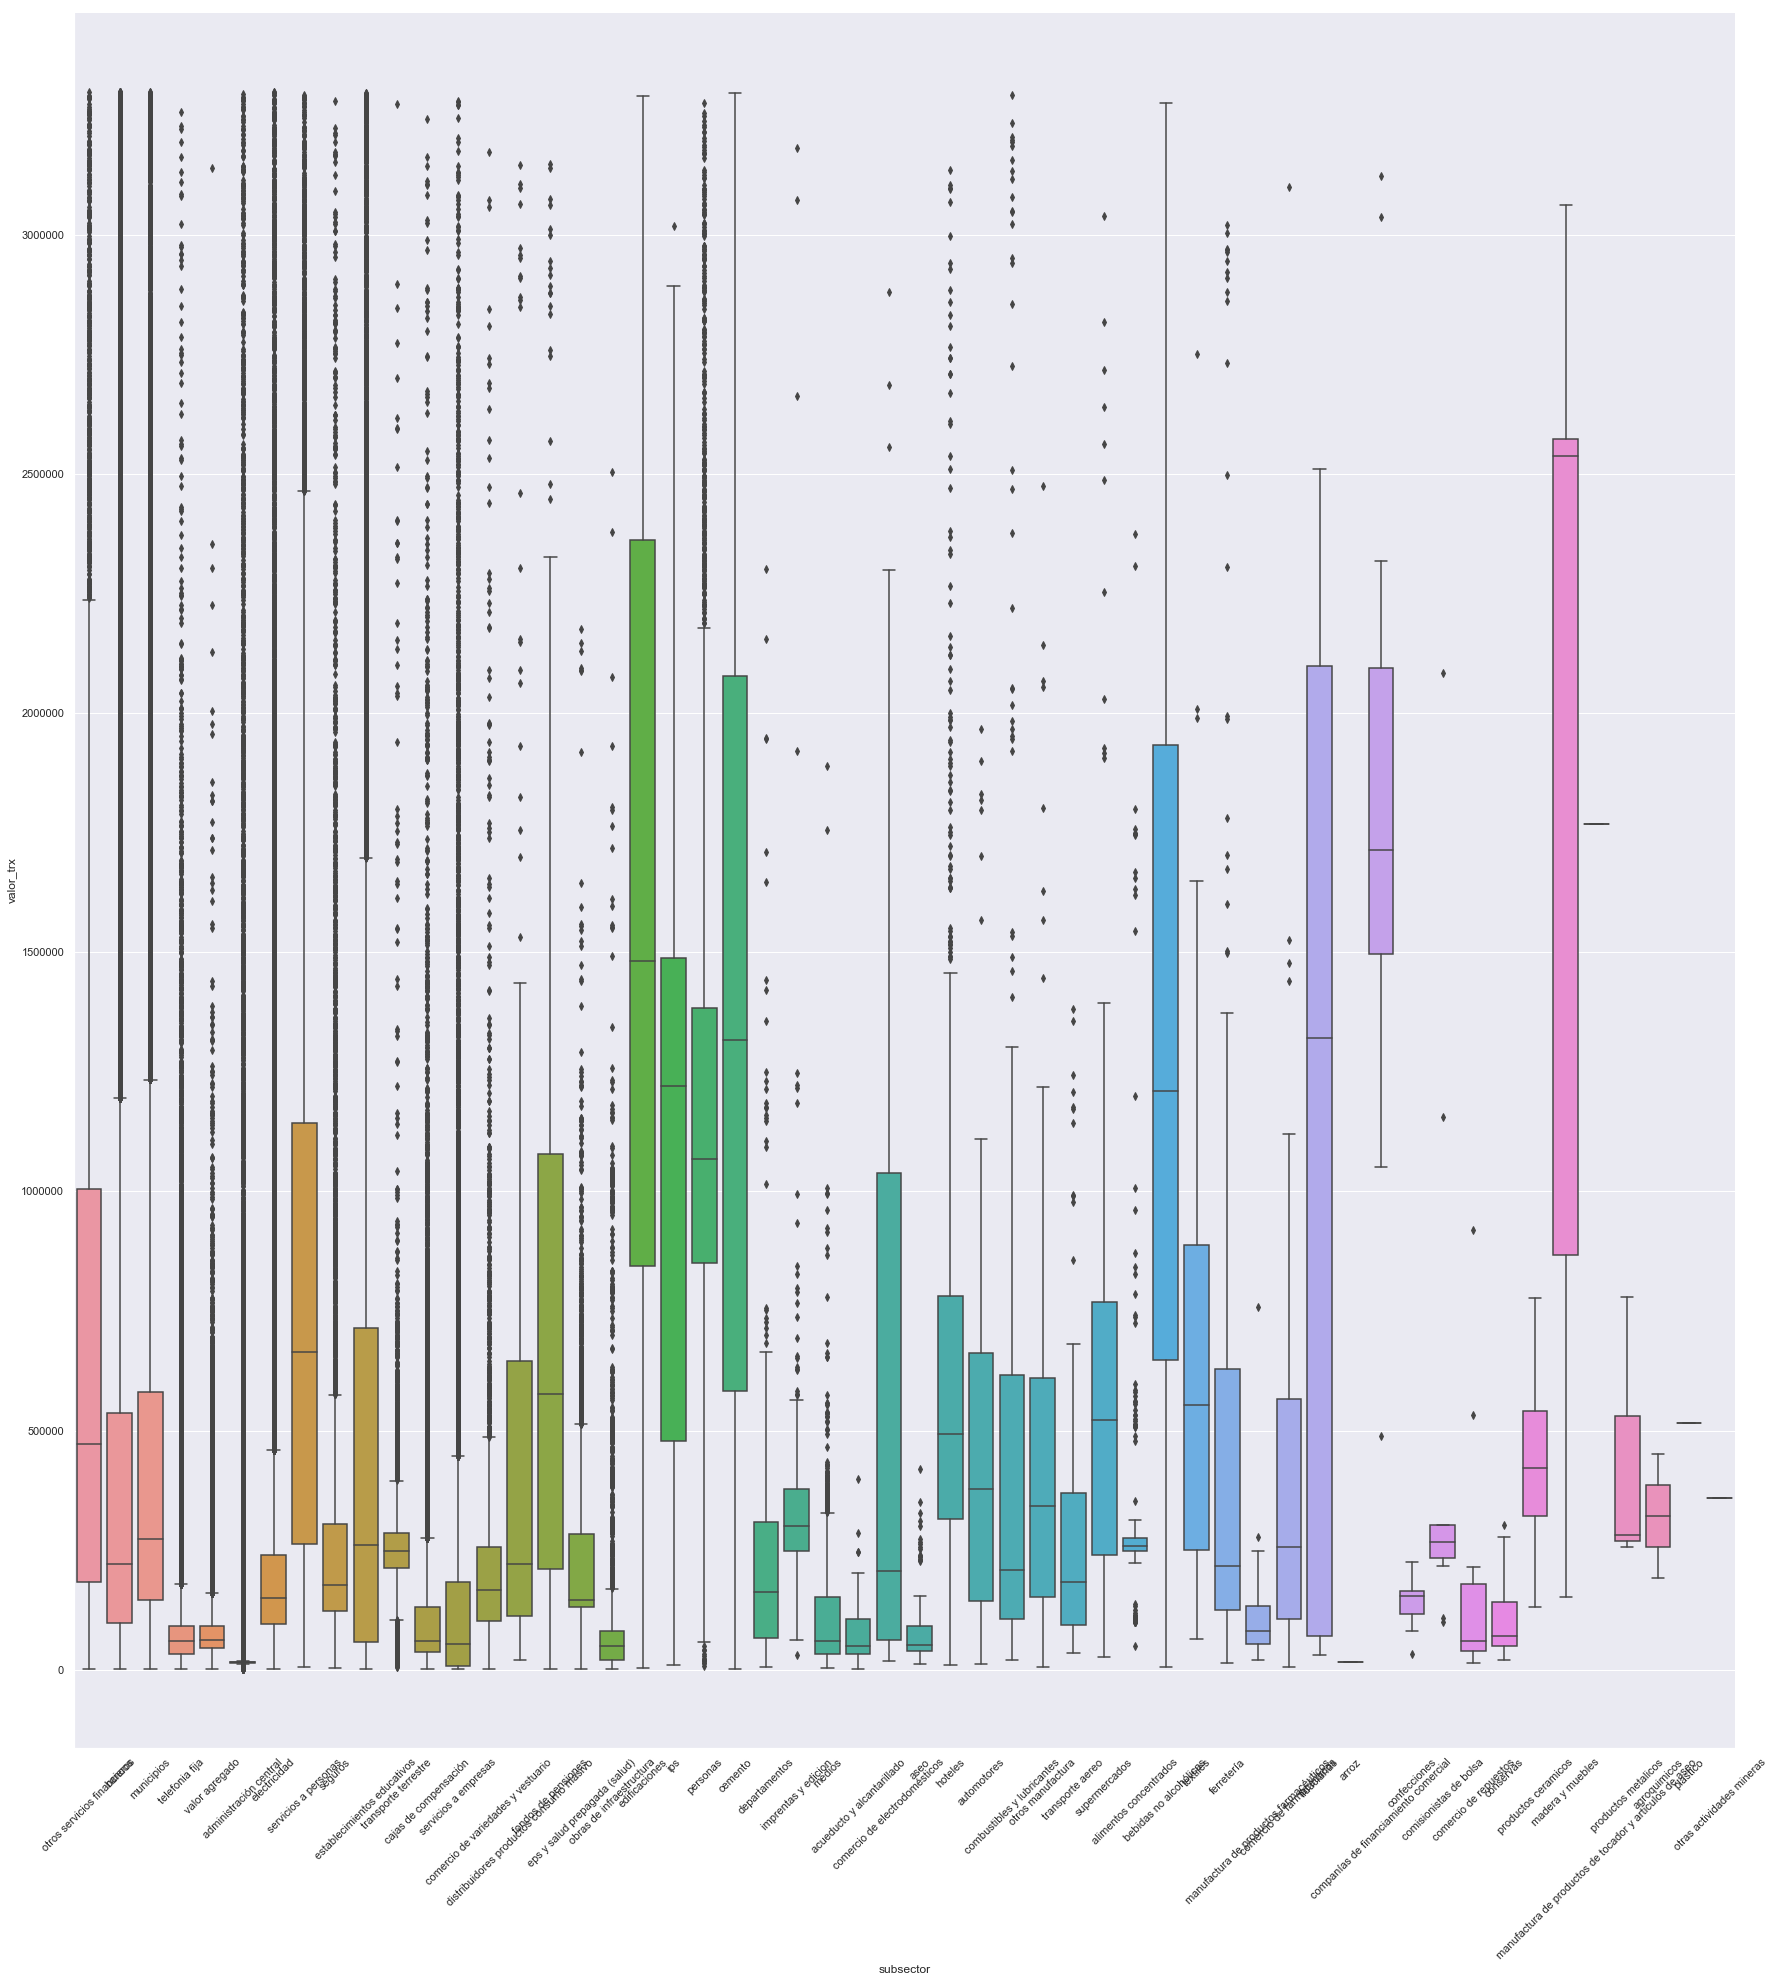

In [26]:
sns.catplot(x="subsector", y="valor_trx", kind="box", data=datos, height=25)
plt.xticks(rotation=45)

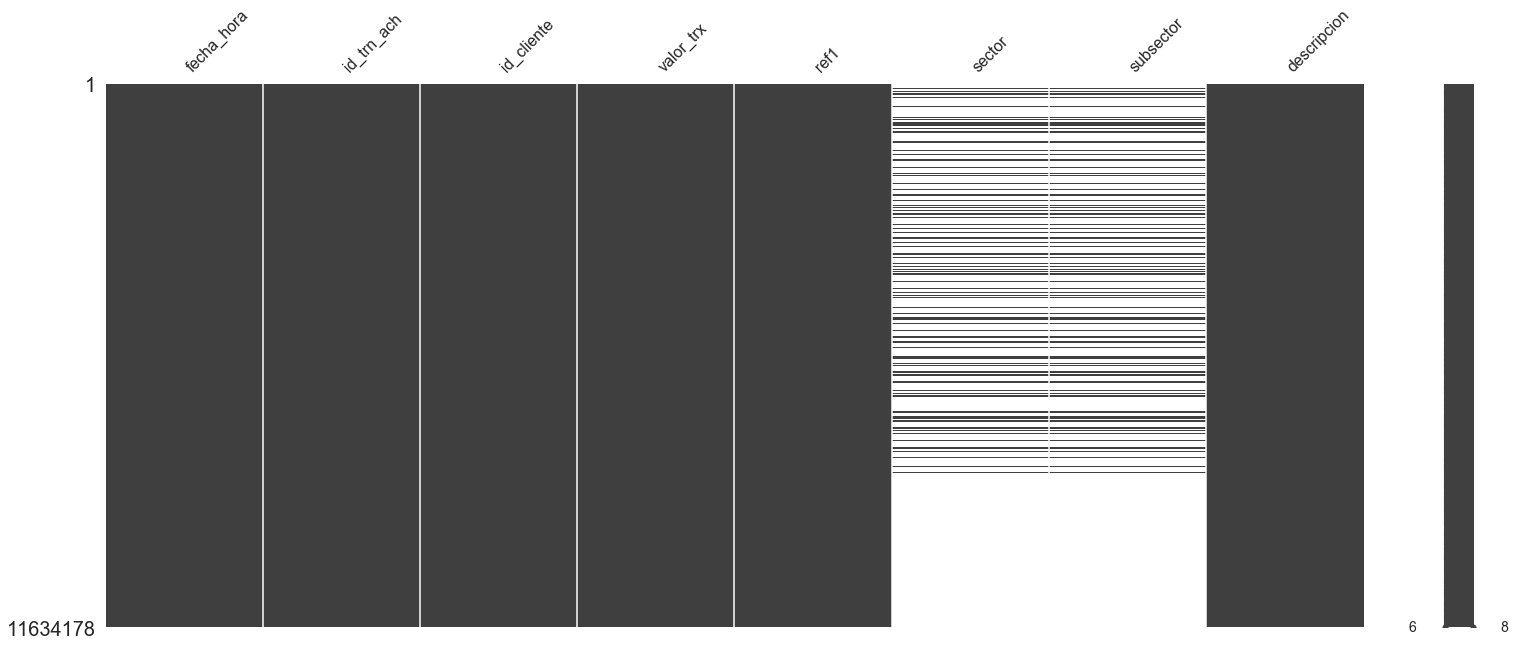

In [27]:
msno.matrix(datos)

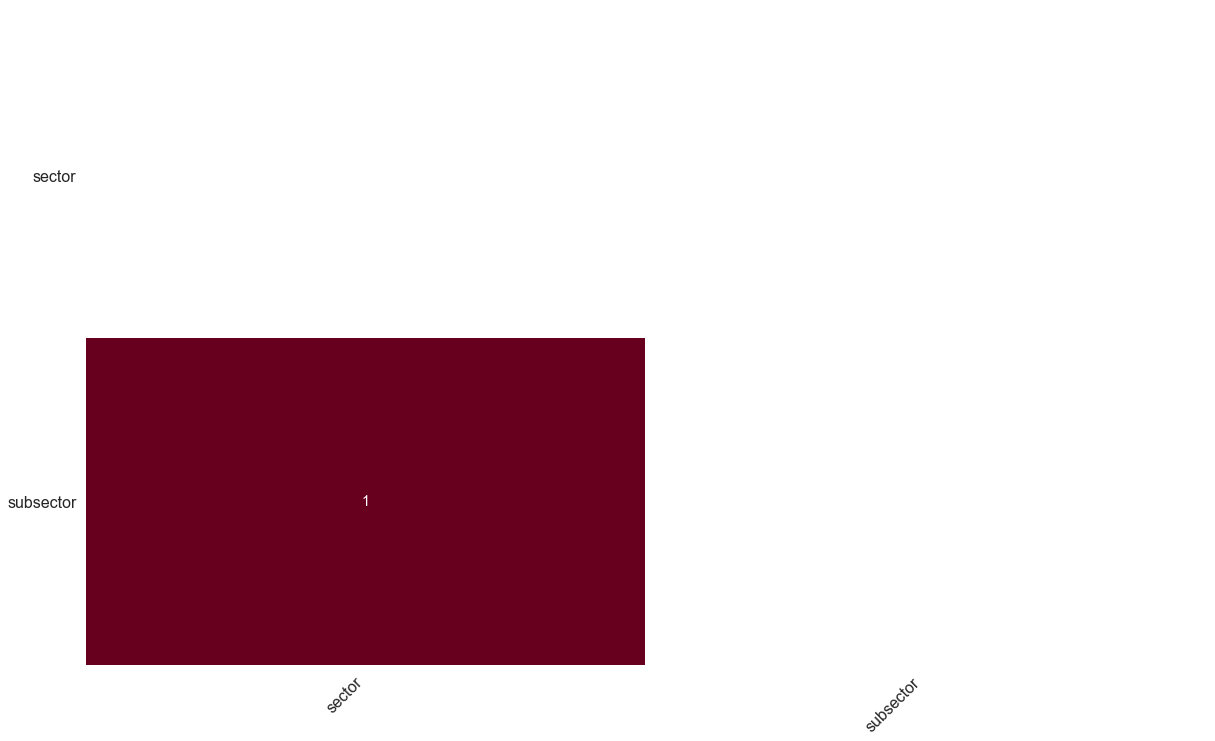

In [28]:
msno.heatmap(datos)